In [1]:
library(chromVAR)
library(Signac)
library(Seurat)
library(tidyverse)
library(GenomicRanges)
library(motifmatchr)
library(JASPAR2020)
library(Matrix)
library(TFBSTools)
setwd("/home/mnt/weka/nzh/team/woodsqu2/nzhanglab/project/linyx/footprints/PRINT/data/Parker_DEFND_aging/all")
source("/home/mnt/weka/nzh/team/woodsqu2/codes/footprints/github/models.R")
source("/home/mnt/weka/nzh/team/woodsqu2/codes/footprints/github/utils.R")
source("/home/mnt/weka/nzh/team/woodsqu2/codes/footprints/github/visualizations.R")




Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.7.0 but the current
version is 1.7.1; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::reduce() masks Signac::reduce()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: stats4

Loading required package: BiocGenerics

#### Run chromvar with footprint-informed peak-by-motif matrix 

##### Load the regions and metadata

In [2]:
regionsBed = read.table("all_peaks_region.bed")
peaks = makeGRangesFromDataFrame(regionsBed)
head(regionsBed)


,chr,start,end
,<chr>,<int>,<int>
1,NC_086019.1,64827,65758
2,NC_086019.1,814869,815735
3,NC_086019.1,1797826,1798772
4,NC_086019.1,3128999,3129968
5,NC_086019.1,3213680,3214896
6,NC_086019.1,3250871,3251828


In [3]:
metadata = read.csv('meta_data.csv', row.name = 1)
head(metadata)


,orig.ident,nCount_ATAC,nFeature_ATAC,ATAC_bc,celltype,dataset
,<chr>,<int>,<int>,<chr>,<chr>,<chr>
weeks_16_ACAGCGGGTTGGGTTT-1,SeuratProject,1584,1522,ACAGCGGGTTGGGTTT-1,PT,weeks_16
weeks_16_ACAGCGGGTTGAGGTA-1,SeuratProject,10832,8154,ACAGCGGGTTGAGGTA-1,PT,weeks_16
weeks_16_ACAGCGGGTGATTCTA-1,SeuratProject,21839,15736,ACAGCGGGTGATTCTA-1,PT,weeks_16
weeks_16_CTTTATCGTTCTTAAG-1,SeuratProject,17317,12071,CTTTATCGTTCTTAAG-1,CNT,weeks_16
weeks_16_TGACTATTCAGGTTGG-1,SeuratProject,4956,4438,TGACTATTCAGGTTGG-1,DCT,weeks_16
weeks_16_TGACTATTCCTTAACG-1,SeuratProject,6615,5350,TGACTATTCCTTAACG-1,IC-A,weeks_16


##### Load the seuratobject and pre-computed binding sites for one age 82 weeks, using only the footprints corresponding to TFs and multi-TF complex sizes.

In [4]:
binding_sites_U21 = readRDS('age_82_weeks/U21/thresholded_binding_sites.rds')
binding_sites_tf = makeGRangesFromDataFrame(binding_sites_U21[binding_sites_U21$width_effect_size <= 120, ])
head(binding_sites_tf, 3)


GRanges object with 3 ranges and 0 metadata columns:
         seqnames          ranges strand
            <Rle>       <IRanges>  <Rle>
  [1] NC_086019.1     65322-65402      *
  [2] NC_086019.1 1798165-1798259      *
  [3] NC_086019.1 3213845-3213881      *
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

In [5]:
seuratobject = readRDS("age_82_weeks/seuratobject_week82_whole_peaks.rds")
seuratobject


An object of class Seurat 
146971 features across 6525 samples within 1 assay 
Active assay: ATAC (146971 features, 146969 variable features)
 2 layers present: counts, data

##### Obtain motif position on the reference genome for peaks

In [6]:
pwm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection="CORE",
              tax_group='vertebrates',
              all_versions=FALSE)
)
genome_file <- Rsamtools::FaFile("/home/mnt/weka/nzh/team/woodsqu2/nzhanglab/data/ParkerWilson_DEFND/reference/fasta/genome.fa")
motif_pos = matchMotifs(pwm, 
                        subject = peaks, 
                        genome = genome_file, 
                        out = 'position')


##### Create the binary peak-by-motif matrix, where each entry is 1 if a binding site of footprint overlaps a motif site within the peak.

In [7]:
motif_fp_matrix = pbmcapply::pbmclapply(seq_along(motif_pos), 
                                        function(i){
                                          motif_peaks = rep(0, length(peaks))
                                          motifs = motif_pos[[i]]
                                          overlaps = findOverlaps(motifs, binding_sites_tf)
                                          motifs = motifs[overlaps@from]
                                          motif_peaks[unique(findOverlaps(peaks, motifs)@from)] = 1
                                          return(motif_peaks)
                                        }, 
                                        mc.cores = 2)

motif_fp_matrix <- do.call(cbind, motif_fp_matrix)
motif_fp_matrix = Matrix::Matrix(motif_fp_matrix, sparse = TRUE)
colnames(motif_fp_matrix) = names(pwm)
rownames(motif_fp_matrix) = paste0(regionsBed$chr, '-', 
                                   regionsBed$start, '-', 
                                   regionsBed$end)


##### Create the standard peak-by-motif matrix

In [8]:
motif_pos = matchMotifs(pwm, 
                        subject = peaks, 
                        genome = genome_file)

motif_matrix = as.matrix(motif_pos@assays@data$motifMatches)
motif_matrix <- Matrix::Matrix(motif_matrix, sparse = TRUE)
motif_matrix <- as(motif_matrix, "dMatrix")
colnames(motif_matrix) = names(pwm)
rownames(motif_matrix) = paste0(regionsBed$chr, '-', 
                                regionsBed$start, '-', 
                                regionsBed$end)


##### Some entries in peak-by-become 0 after restricting to footprinting-supported motif sites

In [9]:
motif_fp_matrix[1:5, 1:5]


5 x 5 sparse Matrix of class "dgCMatrix"
                            MA0004.1 MA0006.1 MA0019.1 MA0029.1 MA0030.1
NC_086019.1-64827-65758            .        .        .        .        .
NC_086019.1-814869-815735          .        .        .        .        .
NC_086019.1-1797826-1798772        .        .        .        .        .
NC_086019.1-3128999-3129968        .        .        .        .        .
NC_086019.1-3213680-3214896        .        .        .        .        .

In [10]:
motif_matrix[1:5, 1:5]


5 x 5 sparse Matrix of class "dgCMatrix"
                            MA0004.1 MA0006.1 MA0019.1 MA0029.1 MA0030.1
NC_086019.1-64827-65758            .        .        .        .        1
NC_086019.1-814869-815735          .        .        .        1        .
NC_086019.1-1797826-1798772        .        .        .        .        .
NC_086019.1-3128999-3129968        .        .        .        .        1
NC_086019.1-3213680-3214896        1        .        .        .        .

##### Run chromvar with standard and footprint-combined peak-by-motif matrix 

In [11]:
seuratobject <- RunChromVAR(
    object = seuratobject,
    assay = 'ATAC',
    motif.matrix = motif_fp_matrix, 
    genome = genome_file, 
    new.assay.name = 'footprint_chromvar'
)
seuratobject[['footprint_chromvar']]


Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay

Warning message:
“Layer counts isn't present in the assay object; returning NULL”


Assay data with 746 features for 6525 cells
First 10 features:
 MA0004.1, MA0006.1, MA0019.1, MA0029.1, MA0030.1, MA0031.1, MA0040.1,
MA0041.1, MA0051.1, MA0057.1 

In [12]:
saveRDS(seuratobject[['footprint_chromvar']], "age_82_weeks/U21/chromvar_footprints_vertebrates_0.05_120.rds")


In [13]:
seuratobject <- RunChromVAR(
    object = seuratobject,
    assay = 'ATAC',
    motif.matrix = motif_matrix, 
    genome = genome_file, 
    new.assay.name = 'standard_chromvar'
)
seuratobject[['standard_chromvar']]


Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay

Warning message:
“Layer counts isn't present in the assay object; returning NULL”


Assay data with 746 features for 6525 cells
First 10 features:
 MA0004.1, MA0006.1, MA0019.1, MA0029.1, MA0030.1, MA0031.1, MA0040.1,
MA0041.1, MA0051.1, MA0057.1 

In [14]:
saveRDS(seuratobject[['standard_chromvar']], "age_82_weeks/U21/chromvar_vertebrates.rds")


#### Differential test of TF activities between different age groups

##### Similarly, run chromvar for other age groups and load the data

In [15]:
weeks82_chromvar_fp = readRDS("age_82_weeks/U21/chromvar_footprints_vertebrates_0.05_120.rds")
weeks30_chromvar_fp = readRDS("age_30_weeks/L12/chromvar_footprints_vertebrates_0.05_120.rds")
weeks82_chromvar = readRDS("age_82_weeks/U21/chromvar_vertebrates.rds")
weeks30_chromvar = readRDS("age_30_weeks/L12/chromvar_vertebrates.rds")


##### Obtain gene names and PT cells for different age groups

In [16]:
motif_names = names(pwm)
gene_names_all = unlist(sapply(motif_names, function(x) {
  getMatrixByID(JASPAR2020, ID = x)@name
}))


In [17]:
weeks82_PT = rownames(metadata)[metadata$celltype %in% c('PT', 'PT-MT') & metadata$dataset == 'weeks_82']
weeks30_PT = rownames(metadata)[metadata$celltype %in% c('PT', 'PT-MT') & metadata$dataset == 'weeks_30']


##### Change of FOSL2 chromVAR scores as aging by different methods 

In [18]:
chromvar_fosl2 <- bind_rows(
  data.frame(
    age = '82 weeks',
    chromvar = weeks82_chromvar@data['MA0478.1', weeks82_PT],
    method = 'standard'
  ),
  data.frame(
    age = '30 weeks',
    chromvar = weeks30_chromvar@data['MA0478.1', weeks30_PT],
    method = 'standard'
  ),
  data.frame(
    age = '82 weeks',
    chromvar = weeks82_chromvar_fp@data['MA0478.1', weeks82_PT],
    method = 'footprint'
  ),
  data.frame(
    age = '30 weeks',
    chromvar = weeks30_chromvar_fp@data['MA0478.1', weeks30_PT],
    method = 'footprint'
  )
)


In [19]:
head(chromvar_fosl2)


,age,chromvar,method
,<chr>,<dbl>,<chr>
weeks_82_ACAGCGGGTTGCTCCT-1...1,82 weeks,-0.6745279,standard
weeks_82_ACAGCGGGTTAAAGGT-1...2,82 weeks,0.6023262,standard
weeks_82_CATTTAGGTTAAGGAT-1...3,82 weeks,0.4672838,standard
weeks_82_GCGCTTAGTTGCTTCC-1...4,82 weeks,0.4030651,standard
weeks_82_GCGCTTAGTTTATTCC-1...5,82 weeks,-3.1431402,standard
weeks_82_GCGCTTAGTGCACAAA-1...6,82 weeks,-1.4760641,standard


Warning message:
“Removed 116 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


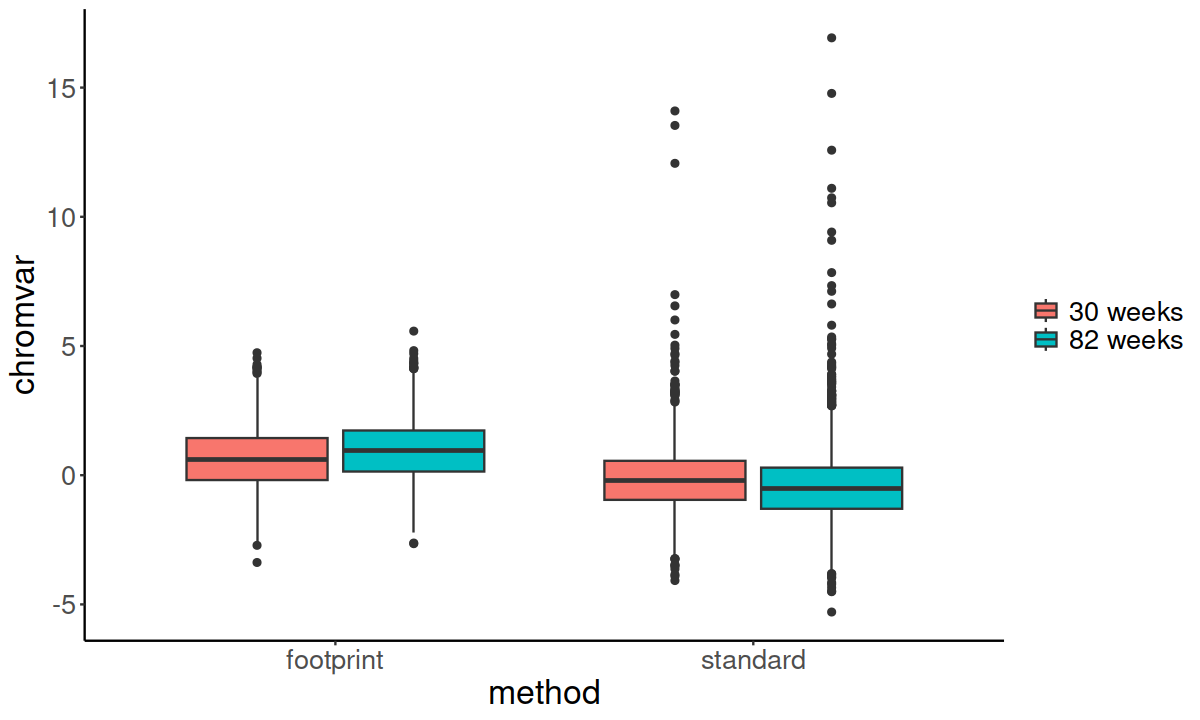

In [20]:
options(repr.plot.width=10, repr.plot.height=6)
ggplot(chromvar_fosl2) + 
    geom_boxplot(aes(x = method, y = chromvar, fill = age)) + 
    theme_classic() +
    theme(legend.title=element_blank(), 
       text = element_text(size = 20))

##### Differential test for footprint-informed chromvar scores

In [21]:
wilcox_stat = NULL
wilcox_pval = NULL
for (tf in motif_names){
  weeks82_value = weeks82_chromvar_fp@data[tf, weeks82_PT]
  weeks30_value = weeks30_chromvar_fp@data[tf, weeks30_PT]
  n1 <- sum(!is.na(weeks82_value))
  n2 <- sum(!is.na(weeks30_value))
  U <- wilcox.test(weeks82_value, 
                   weeks30_value)$statistic
  mu <- n1 * n2 / 2
  sigma <- sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
  z <- (U - mu) / sigma
  
  wilcox_stat = c(wilcox_stat, 
                  z)
  wilcox_pval = c(wilcox_pval,
                  wilcox.test(weeks82_value, 
                              weeks30_value)$p.value
             )
}


In [22]:
wilcox_tf_82_30_fp_chromvar = data.frame('stat' = wilcox_stat, 
                                         'pval' = wilcox_pval, 
                                         'tf' = gene_names_all)
wilcox_tf_82_30_fp_chromvar$pval.adjusted = p.adjust(wilcox_tf_82_30_fp_chromvar$pval, 'fdr')


In [23]:
head(wilcox_tf_82_30_fp_chromvar)


,stat,pval,tf,pval.adjusted
,<dbl>,<dbl>,<chr>,<dbl>
MA0004.1,12.563917,3.334499e-36,Arnt,3.948471e-35
MA0006.1,-6.159319,7.306292e-10,Ahr::Arnt,2.233809e-09
MA0019.1,-6.141090,8.196285e-10,Ddit3::Cebpa,2.495685e-09
MA0029.1,-5.266402,1.391315e-07,Mecom,3.403020e-07
MA0030.1,-1.697674,8.957130e-02,FOXF2,1.144181e-01
MA0031.1,-5.211608,1.872212e-07,FOXD1,4.462206e-07


##### Differential test for standard chromvar scores

In [24]:
wilcox_stat = NULL
wilcox_pval = NULL
for (tf in motif_names){
  weeks82_value = weeks82_chromvar@data[tf, weeks82_PT]
  weeks30_value = weeks30_chromvar@data[tf, weeks30_PT]
  n1 <- sum(!is.na(weeks82_value))
  n2 <- sum(!is.na(weeks30_value))
  U <- wilcox.test(weeks82_value, 
                   weeks30_value)$statistic
  mu <- n1 * n2 / 2
  sigma <- sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
  z <- (U - mu) / sigma
  
  wilcox_stat = c(wilcox_stat, 
                  z)
  wilcox_pval = c(wilcox_pval,
                  wilcox.test(weeks82_value, 
                              weeks30_value)$p.value
             )
}


In [25]:
wilcox_tf_82_30_chromvar = data.frame('stat' = wilcox_stat, 
                                         'pval' = wilcox_pval, 
                                         'tf' = gene_names_all)
wilcox_tf_82_30_chromvar$pval.adjusted = p.adjust(wilcox_tf_82_30_chromvar$pval, 'fdr')


In [26]:
head(wilcox_tf_82_30_chromvar)


,stat,pval,tf,pval.adjusted
,<dbl>,<dbl>,<chr>,<dbl>
MA0004.1,13.0596194,5.601432e-39,Arnt,3.905297e-38
MA0006.1,-4.1905109,2.783391e-05,Ahr::Arnt,4.676599e-05
MA0019.1,-0.7516104,4.522913e-01,Ddit3::Cebpa,4.840880e-01
MA0029.1,-3.5176909,4.353353e-04,Mecom,6.696086e-04
MA0030.1,-4.4248132,9.653019e-06,FOXF2,1.690411e-05
MA0031.1,-2.4836318,1.300538e-02,FOXD1,1.720216e-02


##### Visualizations of chromVAR scores change

In [27]:
wilcox_tf_82_30_fp_chromvar = wilcox_tf_82_30_fp_chromvar[order(wilcox_tf_82_30_fp_chromvar$stat, 
                                                                decreasing = FALSE), ]
wilcox_tf_82_30_fp_chromvar$rank = 1:nrow(wilcox_tf_82_30_fp_chromvar)

wilcox_tf_82_30_chromvar = wilcox_tf_82_30_chromvar[order(wilcox_tf_82_30_chromvar$stat, 
                                                                decreasing = FALSE), ]
wilcox_tf_82_30_chromvar$rank = 1:nrow(wilcox_tf_82_30_chromvar)


In [28]:
gene_interest = c('CTCF', "NRF1", 
                  'STAT1',
                  'BATF', 'FOS', 'FOSL2', 
                  'JUN(var.2)', 'JUND', 'JUNB', 
                  'HNF4A', 'BATF::JUN', 
                  'ATF4', 'BATF3', 
                  'FOS::JUNB'
                  )


In [29]:
plot_chromvar_fp = ggplot(wilcox_tf_82_30_fp_chromvar, aes(x = rank, 
                                             y = stat)) + 
  geom_hline(yintercept = 0, color = 'gray', 
             linetype = 'dashed') +
  geom_point(size = 3, color = '#9ED2BE', alpha = 0.3) + 
  geom_point(data = subset(wilcox_tf_82_30_fp_chromvar, 
                           tf %in% gene_interest), 
             size = 3, color = 'red', alpha = 0.9) + 
  ylab("normalized Wilcoxon stat") + 
  ggrepel::geom_text_repel(data = subset(wilcox_tf_82_30_fp_chromvar, 
                                         tf %in% gene_interest), 
                           color = 'black',
                           aes(label = tf), 
                           box.padding = unit(0.5, 'lines'),
                           point.padding = unit(0.3, 'lines'),
                           max.overlaps = 20, size = 6) +
  theme_classic() + 
  ggtitle("chromVar combined footprint") + 
  scale_x_continuous(labels = NULL, breaks = NULL,
                     limits = c(0, dim(wilcox_tf_82_30_fp_chromvar)[1])) + 
  labs(x = '') +
  theme(legend.title=element_blank(), 
       text = element_text(size = 20))


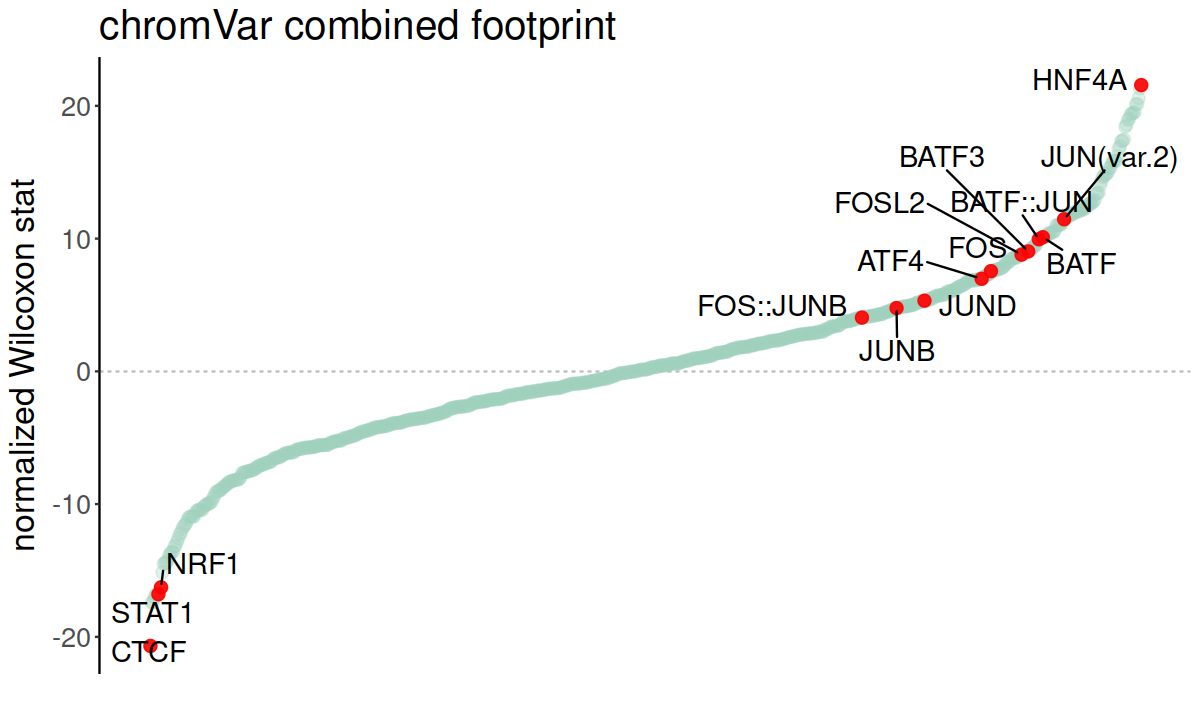

In [30]:
plot_chromvar_fp


In [31]:
plot_chromvar = ggplot(wilcox_tf_82_30_chromvar, aes(x = rank, 
                                             y = stat)) + 
  geom_hline(yintercept = 0, color = 'gray', 
             linetype = 'dashed') +
  geom_point(size = 3, color = '#9ED2BE', alpha = 0.3) + 
  geom_point(data = subset(wilcox_tf_82_30_chromvar, 
                           tf %in% gene_interest), 
             size = 3, color = 'red', alpha = 0.9) + 
  ylab("normalized Wilcoxon stat") + 
  ggrepel::geom_text_repel(data = subset(wilcox_tf_82_30_chromvar, 
                                         tf %in% gene_interest), 
                           color = 'black',
                           aes(label = tf), 
                           box.padding = unit(0.5, 'lines'),
                           point.padding = unit(0.3, 'lines'),
                           max.overlaps = 20, size = 6) +
  theme_classic() + 
  ggtitle("standard chromVar") + 
  scale_x_continuous(labels = NULL, breaks = NULL,
                     limits = c(0, dim(wilcox_tf_82_30_chromvar)[1])) + 
  labs(x = '') +
  theme(legend.title=element_blank(), 
       text = element_text(size = 20))


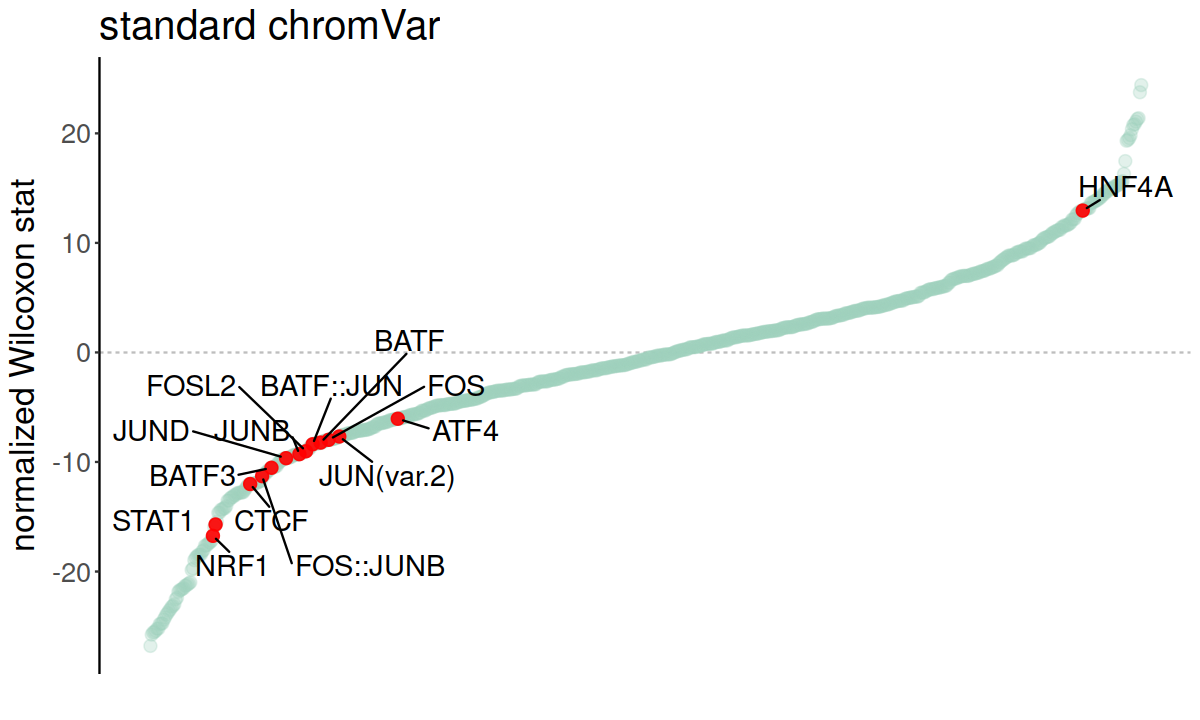

In [32]:
plot_chromvar
